In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import nbinom

warnings.filterwarnings("ignore")

## Synthetic gene expression generation

In [4]:
# Parameters
n_cells = 10000
n_genes = 20
target_zero_prob = 0.8  # Desired overall zero probability

# Simulate gene-specific parameters
np.random.seed(42)
mu_values = np.random.uniform(1, 10, n_genes)         # Mean of NB
theta_values = np.random.uniform(0.5, 2.0, n_genes)   # Dispersion 

# Initialize gene expression matrix
x = np.zeros((n_cells, n_genes), dtype=int)

pi_values = []
# Fill the matrix with ZINB simulated data, solving for pi to match target zero probability
for j in range(n_genes):
    mu = mu_values[j]
    r = 1 / theta_values[j]  

    # Scipy-compatible NB probability
    p = r / (r + mu)

    # Compute probability of zero from NB
    p_nb_zero = nbinom.pmf(0, r, p)

    # Solve for pi to match target overall zero probability
    pi = (target_zero_prob - p_nb_zero) / (1 - p_nb_zero)
    pi = np.clip(pi, 0, 1)  # Ensure it's within [0,1]
    pi_values.append(pi)

    # Simulate NB samples
    nb_samples = nbinom.rvs(r, p, size=n_cells)

    # Apply zero-inflation
    zero_mask = np.random.binomial(1, pi, size=n_cells)
    nb_samples[zero_mask == 1] = 0

    x[:, j] = nb_samples

pi_values = np.array(pi_values)


# Check actual zero proportion
actual_zero_rate = (x == 0).sum() / x.size
print(f"Actual overall zero proportion: {actual_zero_rate:.4f}")

Actual overall zero proportion: 0.7997


In [5]:
def compute_deterministic_gene(x, gene_indices, transformation='sum'):
    subset = x[:, gene_indices]

    if transformation == 'sum':
        return subset.sum(axis=1)
    elif transformation == 'mean':
        return subset.mean(axis=1)
    elif transformation == 'prod':
        return np.prod(subset + 1, axis=1)
    elif transformation == 'tanh':
        return np.tanh(subset.sum(axis=1) / len(gene_indices))
    elif transformation == 'logsum':
        return np.log1p(subset.sum(axis=1))
    else:
        raise ValueError("Unsupported transformation")


In [6]:
def generate_deterministic_combinations_from_indices(x, transformations, index_sets):
    """
    Generate deterministic synthetic genes from specified gene index sets.

    Parameters:
    - x: (n_cells, n_genes) expression matrix
    - transformations: list of transformation names
    - index_sets: list of gene index lists, one per transformation

    Returns:
    - x_deterministic: synthetic gene matrix (n_cells, n_transformations + 1)
    - metadata: list of dicts with transformation + gene indices used
    """
    assert len(transformations) == len(index_sets), "Transformations and index_sets must match."

    synthetic_genes = []
    metadata = []

    for transform, gene_indices in zip(transformations, index_sets):
        g = compute_deterministic_gene(x, gene_indices, transformation=transform)
        synthetic_genes.append(g)
        metadata.append({
            'transformation': transform,
            'gene_indices': gene_indices
        })

    # Add combo-of-combos (mean of all synthetic features)
    x_combined = np.column_stack(synthetic_genes)
    g_meta = compute_deterministic_gene(x_combined, list(range(len(transformations))), transformation='mean')
    
    synthetic_genes.append(g_meta)
    metadata.append({
        'transformation': 'mean (combo of combos)',
        'gene_indices': list(range(len(transformations)))
    })

    x_deterministic = np.column_stack(synthetic_genes)
    return x_deterministic, metadata


In [7]:
np.random.seed(0)
transformations = ['sum', 'mean', 'prod', 'tanh', 'logsum']
index_sets = [np.random.choice(n_genes, size=n_genes//2, replace=False).tolist()
                for _ in transformations]

x_deterministic, metadata = generate_deterministic_combinations_from_indices(
    x,
    transformations,
    index_sets
)

# Optional: View metadata
import pandas as pd
pd.DataFrame(metadata)


,transformation,gene_indices
0,sum,"[18, 1, 19, 8, 10, 17, 6, 13, 4, 2]"
1,mean,"[11, 1, 18, 17, 2, 12, 19, 16, 10, 0]"
2,prod,"[15, 13, 12, 5, 11, 2, 8, 6, 3, 17]"
3,tanh,"[18, 0, 13, 2, 3, 17, 7, 12, 14, 16]"
4,logsum,"[7, 1, 2, 19, 5, 18, 8, 17, 15, 16]"
5,mean (combo of combos),"[0, 1, 2, 3, 4]"


In [ ]:
np.hstack([x, x_combo]).shape

(10000, 25)

In [ ]:
x = np.hstack([x, x_combo])

In [28]:
np.argmax(x_combo, keepdims=True)

array([[23552]])

In [ ]:
# Simulate a gene that's the product of genes 1, 3, and 5
g_combo, mu_c, theta_c, pi_c = create_combination_gene(
    x,
    gene_indices=[1, 3, 5],
    transformation='prod'
)

In [ ]:
(np.log(x[:,0] + x[:,1] + 1) < 0).any()


np.False_

In [ ]:
mu1 = np.log(x[:,0] + x[:,1] + 1)


In [ ]:
x[:,2]

## ! Add systematic batch effect on 1/2 of cells


In [3]:
adata = sc.AnnData(X=x)
adata.obs['batch'] = 0
adata.obs["batch"].iloc[:n_cells//2] = 1
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'batch'

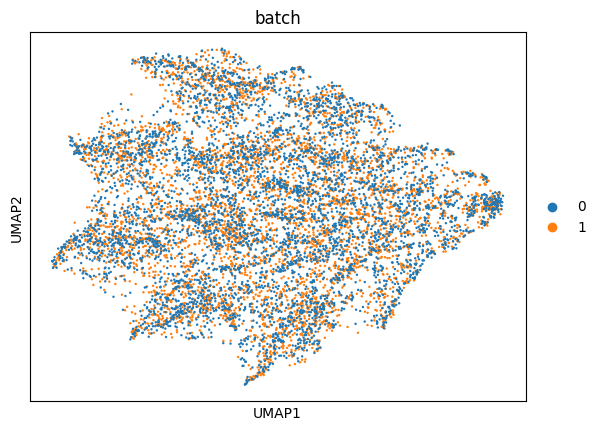

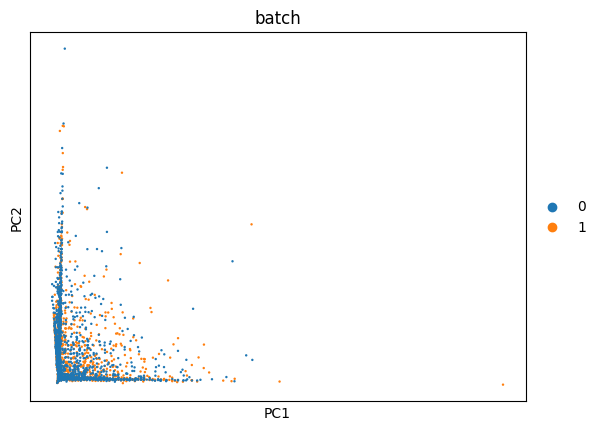

In [76]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.pca(adata)
sc.pl.umap(adata, color='batch')
sc.pl.pca(adata, color='batch')

In [77]:
x[:n_cells//2,:] += 10
#x *= mask
x

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 14, 10],
       [17, 10, 10, ..., 10, 10, 10],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 6,  0,  3, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0]])

In [78]:
adata = sc.AnnData(X=x)
adata.obs['batch'] = 0
adata.obs["batch"].iloc[:n_cells//2] = 1
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'batch'

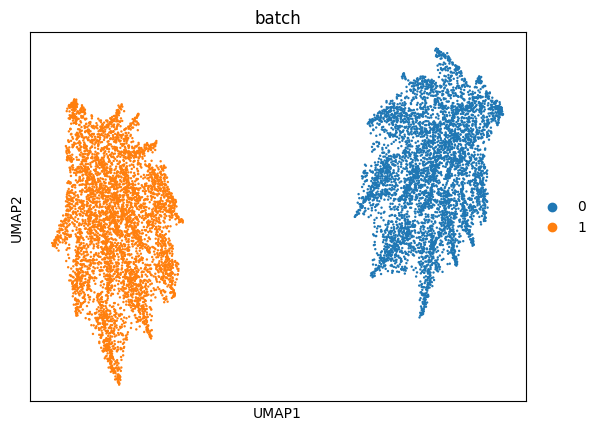

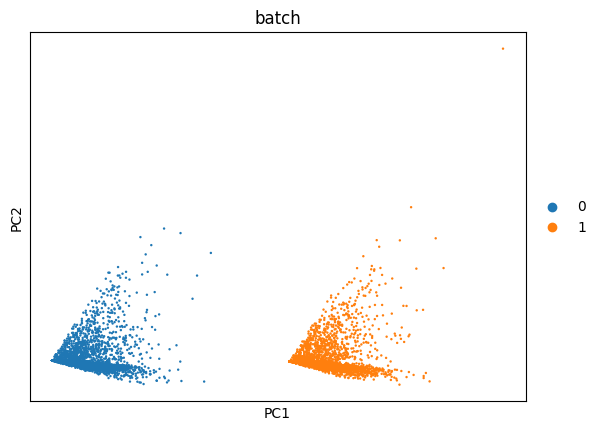

In [79]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.pca(adata)
sc.pl.umap(adata, color='batch')
sc.pl.pca(adata, color='batch')

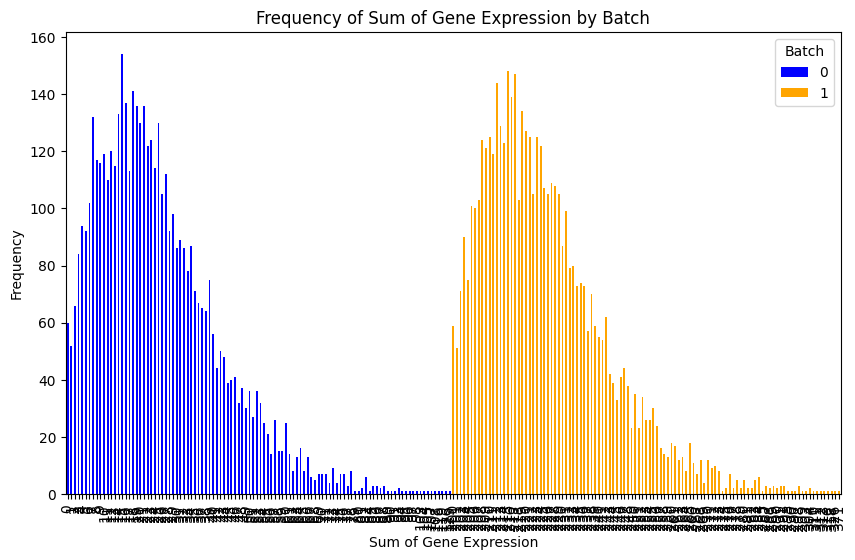

In [80]:
adata.obs["sum_expression"] = adata.X.sum(axis=1)
sum_counts_batch = adata.obs.groupby(["sum_expression", "batch"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["blue", "orange"]  # Assuming two batches: 0 and 1
sum_counts_batch.plot(kind="bar", stacked=True, color=colors, ax=ax)

ax.set_xlabel("Sum of Gene Expression")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of Sum of Gene Expression by Batch")
plt.legend(title="Batch")
plt.show()

## Architecture and loss definition

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# ZINB LOSS FUNCTION
# ----------------------------
class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda

    def forward(self, x, mean, dispersion, pi, scale_factor=1.0):
        x = x.float()
        mean = mean * scale_factor

        nb_case = (
            torch.lgamma(dispersion + self.eps)
            + torch.lgamma(x + 1.0)
            - torch.lgamma(x + dispersion + self.eps)
            - dispersion * torch.log(dispersion + self.eps)
            - x * torch.log(mean + self.eps)
            + (dispersion + x) * torch.log(dispersion + mean + self.eps)
        )

        zero_case = -torch.log(pi + ((1.0 - pi) * torch.exp(-nb_case)) + self.eps)

        result = torch.where(torch.lt(x, 1e-8), zero_case, -torch.log(1.0 - pi + self.eps) + nb_case)
        ridge = self.ridge_lambda * (pi ** 2).sum()

        return result.mean() + ridge


# ----------------------------
# ENCODER
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# ----------------------------
# DECODER (Conditional on Batch)
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_batches):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + n_batches, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_disp = nn.Linear(hidden_dim, output_dim)
        self.fc_pi = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, batch_onehot):
        z_cond = torch.cat([z, batch_onehot], dim=-1)
        h = F.relu(self.fc1(z_cond))
        mean = torch.exp(self.fc_mean(h))
        dispersion = torch.exp(self.fc_disp(h))
        pi = torch.sigmoid(self.fc_pi(h))
        return mean, dispersion, pi


# ----------------------------
# VAE MODULE
# ----------------------------
class ZINBVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_batches):
        super(ZINBVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_batches)
        self.zinb_loss_fn = ZINBLoss()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, batch_onehot):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        mean, disp, pi = self.decoder(z, batch_onehot)
        return mean, disp, pi, mu, logvar, z

    def loss_function(self, x, mean, disp, pi, mu, logvar):
        zinb_loss = self.zinb_loss_fn(x, mean, disp, pi)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return zinb_loss + kl_div


## Set seed and training loop

No dataloader for simplicity

In [82]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False



In [83]:
true_mu_tensor = torch.tensor(np.tile(mu_values, (n_cells, 1)) , dtype=torch.float32)
true_theta_tensor = torch.tensor(np.tile(theta_values, (n_cells, 1)), dtype=torch.float32)
true_pi_tensor = torch.tensor(np.tile(pi_values, (n_cells, 1)), dtype=torch.float32)

In [92]:
# Set the seed
set_seed(11)
vae = ZINBVAE(input_dim=n_genes, hidden_dim=30, latent_dim=5, n_batches=2)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
x = torch.tensor(x, dtype=torch.float32)
batch_onehot = F.one_hot(torch.tensor(adata.obs["batch"], dtype=torch.long), num_classes=2)

vae.train()
for epoch in range(1000):
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x, batch_onehot)
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    loss.backward()
    optimizer.step()
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    with torch.no_grad():
        if epoch == 0:
            mean_mse = F.mse_loss(mean, true_mu_tensor).item()
            theta_mse = F.mse_loss(disp, true_theta_tensor).item()
            pi_mse = F.mse_loss(pi, true_pi_tensor).item()
    
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Mean MSE: {mean_mse:.4f}, Theta MSE: {theta_mse:.4f}, Pi MSE: {pi_mse:.4f}")
    
    if epoch>0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 14.1976, Mean MSE: 341.5573, Theta MSE: 148.4806, Pi MSE: 0.0642
Epoch 1, Loss: 12.5037
Epoch 2, Loss: 11.2154
Epoch 3, Loss: 10.2358
Epoch 4, Loss: 9.4716
Epoch 5, Loss: 8.8671
Epoch 6, Loss: 8.3822
Epoch 7, Loss: 7.9871
Epoch 8, Loss: 7.6557
Epoch 9, Loss: 7.3733
Epoch 10, Loss: 7.1361
Epoch 11, Loss: 6.9261
Epoch 12, Loss: 6.7449
Epoch 13, Loss: 6.5902
Epoch 14, Loss: 6.4517
Epoch 15, Loss: 6.3296
Epoch 16, Loss: 6.2188
Epoch 17, Loss: 6.1259
Epoch 18, Loss: 6.0436
Epoch 19, Loss: 5.9685
Epoch 20, Loss: 5.8997
Epoch 21, Loss: 5.8309
Epoch 22, Loss: 5.7699
Epoch 23, Loss: 5.7078
Epoch 24, Loss: 5.6532
Epoch 25, Loss: 5.5991
Epoch 26, Loss: 5.5403
Epoch 27, Loss: 5.4810
Epoch 28, Loss: 5.4287
Epoch 29, Loss: 5.3785
Epoch 30, Loss: 5.3202
Epoch 31, Loss: 5.2639
Epoch 32, Loss: 5.2140
Epoch 33, Loss: 5.1505
Epoch 34, Loss: 5.1054
Epoch 35, Loss: 5.0480
Epoch 36, Loss: 5.0086
Epoch 37, Loss: 4.9566
Epoch 38, Loss: 4.9079
Epoch 39, Loss: 4.8673
Epoch 40, Loss: 4.8191
Epoch 

In [93]:
# Set the seed
set_seed(11)

batch_onehot_new = torch.tile(batch_onehot[-1], (n_cells, 1))

vae.eval()
with torch.no_grad():
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x, batch_onehot_new)
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    mean_mse = F.mse_loss(mean, true_mu_tensor).item()
    theta_mse = F.mse_loss(disp, true_theta_tensor).item()
    pi_mse = F.mse_loss(pi, true_pi_tensor).item()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Mean MSE: {mean_mse:.4f}, Theta MSE: {theta_mse:.4f}, Pi MSE: {pi_mse:.4f}")


Epoch 999, Loss: 3.4054, Mean MSE: 2.3911, Theta MSE: 0.5246, Pi MSE: 0.0050


In [94]:
adata.obsm["z"] = z.detach().numpy()
adata.obsm["mean"] = mean.detach().numpy()
adata.obsm["dispersion"] = disp.detach().numpy()
adata.obsm["pi"] = pi.detach().numpy()

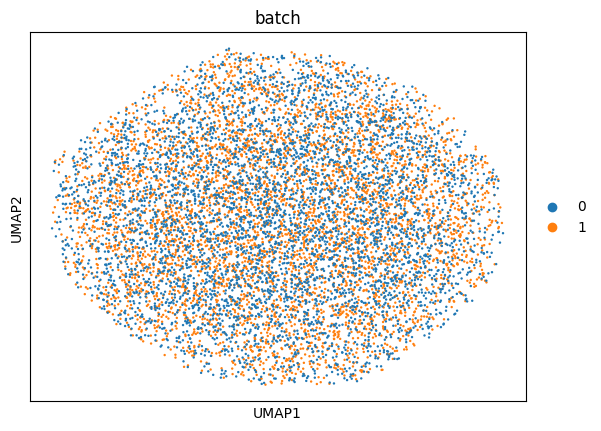

In [95]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

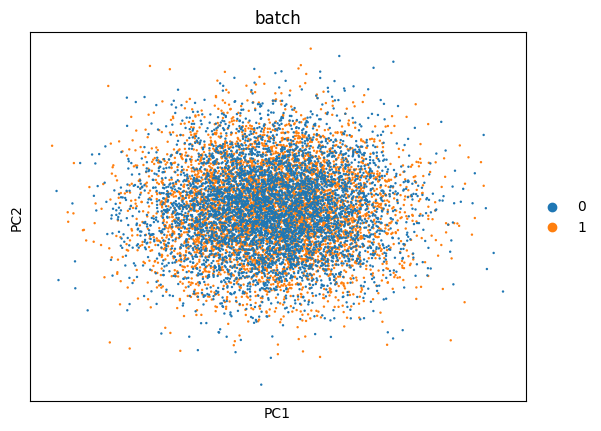

In [96]:
adata_test = sc.AnnData(X=z.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch')

In [97]:
"""import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(x.sum(1), label='Input', color='blue', stat='density', kde=True, bins=50, alpha=0.5)
sns.histplot(adata.obsm["zinb_output"].sum(1), label='Decoder Output', color='orange', stat='density', kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Counts per Cell")
plt.ylabel("Density")
plt.title("Distribution of Total Counts per Cell")
plt.legend()
plt.tight_layout()
plt.show()
"""

'import seaborn as sns\n\nplt.figure(figsize=(8, 5))\nsns.histplot(x.sum(1), label=\'Input\', color=\'blue\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nsns.histplot(adata.obsm["zinb_output"].sum(1), label=\'Decoder Output\', color=\'orange\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nplt.xlabel("Total Counts per Cell")\nplt.ylabel("Density")\nplt.title("Distribution of Total Counts per Cell")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [98]:
def sample_zinb(mean, disp, pi, eps=1e-8):
    """
    Sample counts from a Zero-Inflated Negative Binomial distribution.

    Parameters:
        mean: Tensor [n_cells, n_genes]
        disp: Tensor [n_cells, n_genes]
        pi:   Tensor [n_cells, n_genes]

    Returns:
        samples: Tensor [n_cells, n_genes]
    """
    # Ensure tensors are on the same device
    mean, disp, pi = mean.to(torch.float32), disp.to(torch.float32), pi.to(torch.float32)

    # Compute NB parameters
    p = mean / (mean + disp + eps)  # success probability
    r = disp  # number of failures

    # Gamma-Poisson sampling trick for NB
    gamma_sample = torch._standard_gamma(r)
    nb_sample = torch.poisson(gamma_sample * (p / (1 - p + eps)))

    # Apply zero inflation
    keep_mask = torch.bernoulli(1.0 - pi)  # 1 = keep, 0 = zero-inflate
    zinb_sample = nb_sample * keep_mask

    return zinb_sample

set_seed(11)
zinb_sample = sample_zinb(mean, disp, pi)
zinb_sample

tensor([[15.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4., 50.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  8.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

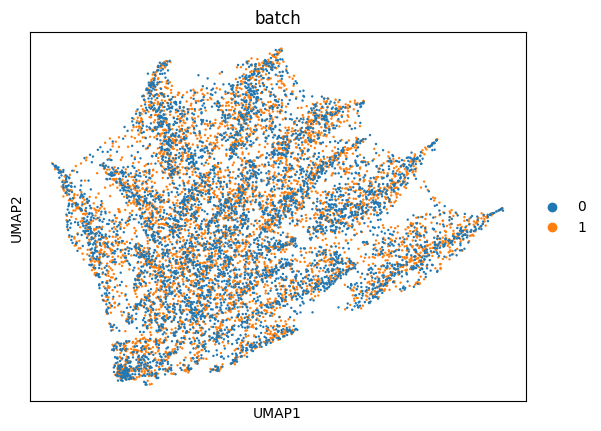

In [99]:
adata.obsm["zinb_sample"] = zinb_sample.detach().numpy()

sc.pp.neighbors(adata, use_rep="zinb_sample")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')


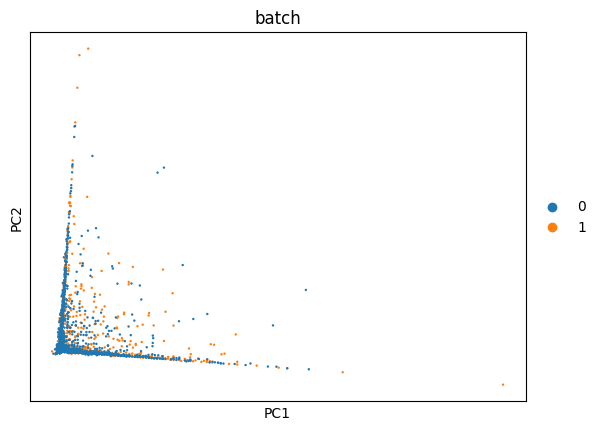

In [100]:
adata_test = sc.AnnData(X=zinb_sample.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch', layer="z")

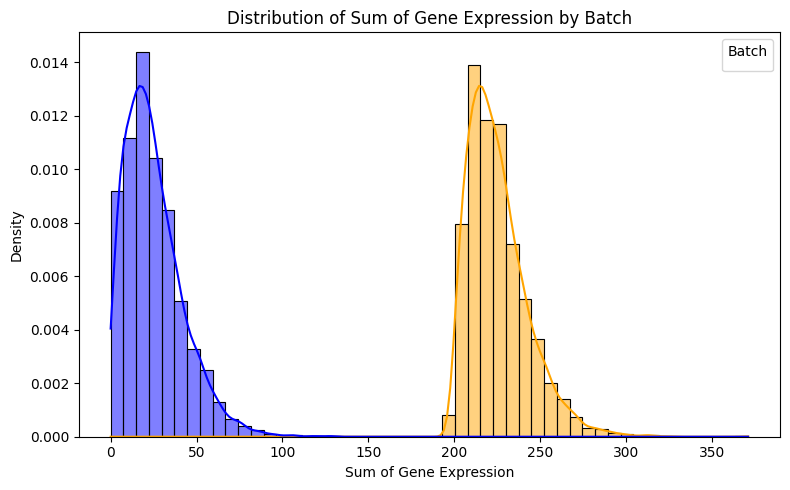

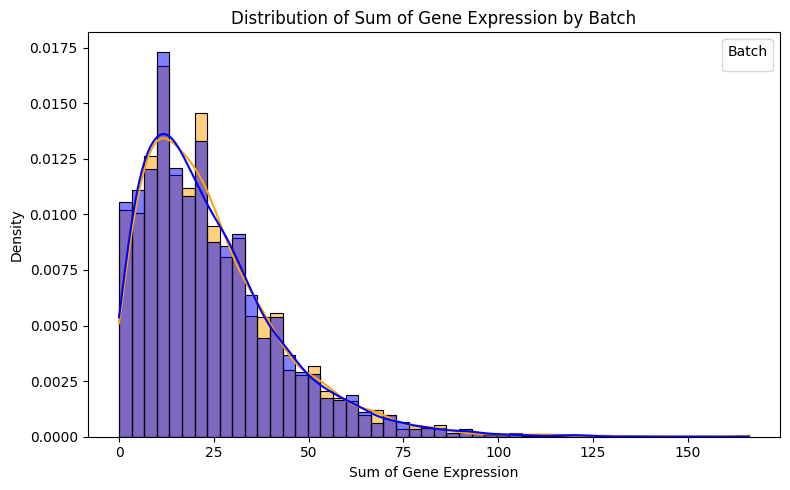

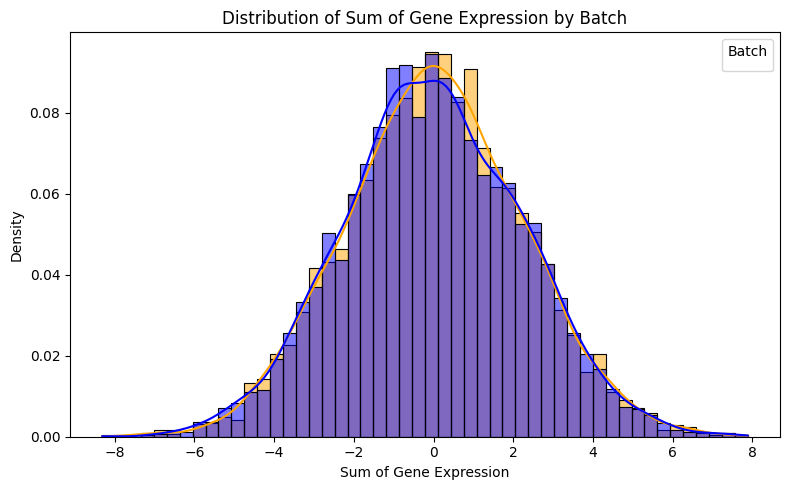

In [101]:
# Convert the sum of gene expression to a pandas DataFrame for plotting
adata.obs["sum_expression"] = adata.X.sum(1)  # Ensure sum_expression is in obs
adata.obs["z"] = adata.obsm["z"].sum(1)
adata.obs["mean"] = adata.obsm["mean"].sum(1)
adata.obs["zinb_sample"] = adata.obsm["zinb_sample"].sum(1)


for key in ["sum_expression", "zinb_sample", "z"]:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=adata.obs, x=key, hue="batch", palette=colors, stat="density", kde=True, bins=50, alpha=0.5)
    plt.xlabel("Sum of Gene Expression")
    plt.ylabel("Density")
    plt.title("Distribution of Sum of Gene Expression by Batch")
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

In [102]:
loss

tensor(3.4054)